<a href="https://colab.research.google.com/github/piyush-an/INFO7374_Predict_StockPrice/blob/main/3_Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part - 3: Visualize the feature importance and feature selection process
- Regression based approach, such as Ridge regression, LASSO, Elastic Net or LARS

    `vs`

- Decision tree based approach (random forest, XGBoost)

## Importing libraries

In [1]:
%%bash

pip install pandas yfinance ta seaborn matplotlib pandas-datareader jinja2 fredapi openpyxl xgboost scikit-learn statsmodels mlflow

You should consider upgrading via the '/Users/anshumankaran/Documents/GitHub/INFO7374_Predict_StockPrice/.env/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import math
from xgboost import XGBRegressor
import math
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (15, 20)

## MLFlow Experiment Tracking

In [4]:
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "http://localhost:5001"
SET_EXPERIMENT = "INFO7374_team_nvdia"
EXPERIMENT_ID = "5"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(SET_EXPERIMENT)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
mlflow.sklearn.autolog(silent=True)
mlflow.xgboost.autolog(silent=True)
mlflow.statsmodels.autolog()

2024/01/11 00:19:22 INFO mlflow.tracking.fluent: Experiment with name 'INFO7374_team_nvdia' does not exist. Creating a new experiment.
2024/01/11 00:19:25 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.


## Train & Test Data Split

In [5]:
nvda = pd.read_csv("https://raw.githubusercontent.com/piyush-an/INFO7374_Predict_StockPrice/main/NVDA_feature_mart.csv")
nvda.set_index("Unnamed: 0", inplace=True)

nvda.index = pd.to_datetime(nvda.index)
nvda = nvda[nvda.index >= pd.to_datetime("2022-01-01")]
split_date = pd.to_datetime("2023-07-31")

df_train = nvda[nvda.index <= split_date]
df_test = nvda[nvda.index > split_date]

print(f"Number of rows in df_train: {len(df_train)}")
print(f"Number of rows in df_test: {len(df_test)}")

columns_to_keep = []
columns_to_drop = ["Open", "High", "Low", "Typical_Price", "Adj Close"]

X_train = df_train.loc[:, df_train.columns != "Close"][:-1]
X_train = X_train.drop(columns_to_drop, axis=1)
y_train = df_train["Close"].shift(-1)[:-1]

X_test = df_test.loc[:, df_test.columns != "Close"][:-1]
X_test = X_test.drop(columns_to_drop, axis=1)
y_test = df_test["Close"].shift(-1)[:-1]

Number of rows in df_train: 393
Number of rows in df_test: 64


## Elastic Net

In [7]:
with mlflow.start_run():
    model = ElasticNet(alpha=1.0, fit_intercept=False).fit(X_train, y_train)
    selected_columns = X_train.columns[np.abs(model.coef_) >= 0.001]
    X_train_selected = X_train[selected_columns]
    X_test_selected = X_test[selected_columns]

    # Fit an OLS model on the selected features
    EN_Model = sm.OLS(y_train, sm.add_constant(X_train_selected)).fit()
    y_pred = EN_Model.predict(sm.add_constant(X_test_selected))

    # Calculate RMSE
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = math.sqrt(MSE)

    # Log metrics and tag the model
    mlflow.set_tag("model", "ElasticNet")
    mlflow.set_tag("runtype", "FeatureSelection")
    mlflow.log_metric("RMSE", RMSE)

/Users/anshumankaran/Documents/GitHub/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.212e+04, tolerance: 2.314e+03
  model = cd_fast.enet_coordinate_descent(


/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_51793/3417088234.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  significant_p_values_en = [p_values_en[i] for i in significant_features_indices_en]


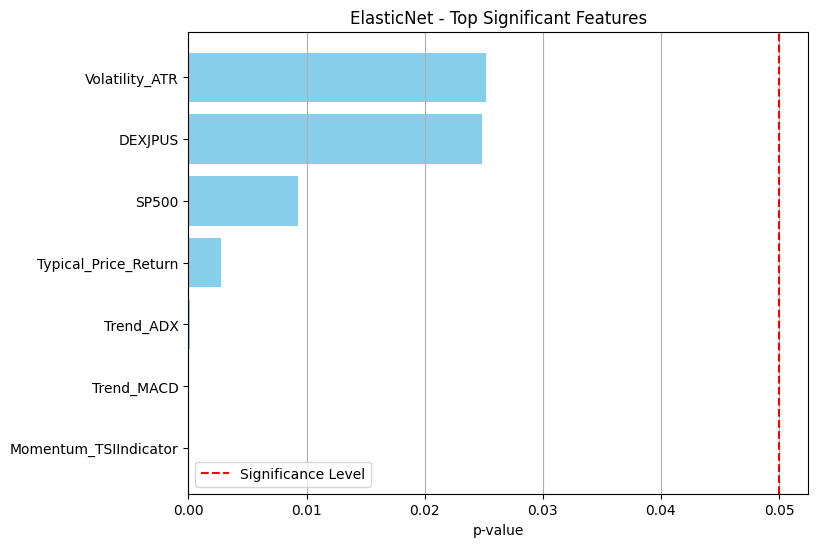

In [8]:
# Extract p-values
p_values_en = EN_Model.pvalues

# Set a significance level (e.g., 0.05)
significance_level = 0.05

# Get indices of significant features based on p-values
significant_features_indices_en = [i for i, p_val in enumerate(p_values_en) if p_val < significance_level]

# Get the names of significant features and their corresponding p-values
significant_features_en = [X_train_selected.columns[i] for i in significant_features_indices_en]
significant_p_values_en = [p_values_en[i] for i in significant_features_indices_en]

# Sort features based on their p-values
sorted_indices_en = np.argsort(significant_p_values_en)  # Sort indices in ascending order of p-values

sorted_features_en = [significant_features_en[i] for i in sorted_indices_en]
sorted_p_values_en = [significant_p_values_en[i] for i in sorted_indices_en]

# Plotting
plt.figure(figsize=(8, 6))
plt.barh(sorted_features_en, sorted_p_values_en, color='skyblue')
plt.xlabel('p-value')
plt.title('ElasticNet - Top Significant Features')
plt.axvline(x=significance_level, color='red', linestyle='--', label='Significance Level')
plt.legend()
plt.grid(axis='x')
plt.show()

## Lasso

In [9]:
with mlflow.start_run():
    model = Lasso(alpha=0.5, fit_intercept=False).fit(X_train, y_train)
    selected_columns = X_train.columns[np.abs(model.coef_) >= 0.001]
    X_train_selected = X_train[selected_columns]
    X_test_selected = X_test[selected_columns]

    Lasso_Model = sm.OLS(y_train, sm.add_constant(X_train_selected)).fit()
    y_pred = Lasso_Model.predict(sm.add_constant(X_test_selected))
    corr_model = np.corrcoef(y_pred, y_test, rowvar=False)[0, 1]

    MSE = mean_squared_error(y_test, y_pred)
    RMSE = math.sqrt(MSE)

    print(Lasso_Model.summary())

    mlflow.set_tag("model", "LARS")
    mlflow.set_tag("runtype", "FeatureSelection")
    mlflow.log_metric("RMSE", RMSE)

/Users/anshumankaran/Documents/GitHub/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e+04, tolerance: 2.314e+03
  model = cd_fast.enet_coordinate_descent(


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1392.
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:21:50   Log-Likelihood:                -1402.2
No. Observations:                 392   AIC:                             2858.
Df Residuals:                     365   BIC:                             2966.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_51793/2405930759.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  significant_p_values = [p_values[i] for i in significant_features_indices]


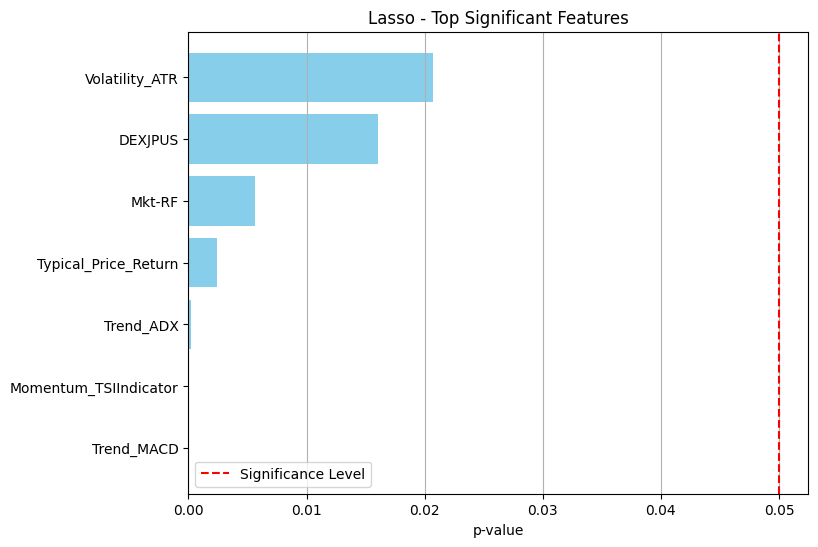

In [10]:
p_values = Lasso_Model.pvalues

# Set a significance level (e.g., 0.05)
significance_level = 0.05

# Get indices of significant features based on p-values
significant_features_indices = [i for i, p_val in enumerate(p_values) if p_val < significance_level]

# Get the names of significant features and their corresponding p-values
significant_features = [X_train_selected.columns[i] for i in significant_features_indices]
significant_p_values = [p_values[i] for i in significant_features_indices]

# Sort features based on their p-values
sorted_indices = np.argsort(significant_p_values)  # Sort indices in ascending order of p-values

sorted_features = [significant_features[i] for i in sorted_indices]
sorted_p_values = [significant_p_values[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(8, 6))
plt.barh(sorted_features, sorted_p_values, color='skyblue')
plt.xlabel('p-value')
plt.title('Lasso - Top Significant Features')
plt.axvline(x=significance_level, color='red', linestyle='--', label='Significance Level')
plt.legend()
plt.grid(axis='x')
plt.show()

## Ordinary Least Squares (OLS) Regression

In [11]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

with mlflow.start_run():
    OLS_Model = sm.OLS(y_train, X_train_const).fit()
    print(OLS_Model.summary())
    y_pred = OLS_Model.predict(X_test_const)

    MSE = mean_squared_error(y_test, y_pred, squared=False)
    RMSE = math.sqrt(MSE)

    mlflow.set_tag("model", "OLS")
    mlflow.set_tag("runtype", "FeatureSelection")
    mlflow.log_metric("RMSE", RMSE)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     903.8
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:25:57   Log-Likelihood:                -1374.1
No. Observations:                 392   AIC:                             2838.
Df Residuals:                     347   BIC:                             3017.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/var/folders/73/z3xw9gmn0yv1ytg8yv66975w0000gn/T/ipykernel_51793/2165119943.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  significant_p_values_ols = [p_values_ols[i] for i in significant_features_indices_ols]


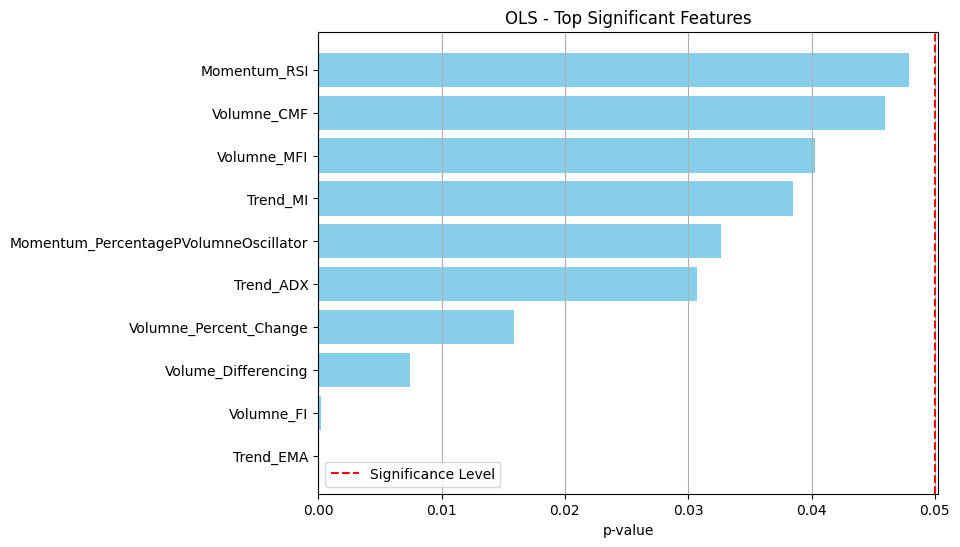

In [12]:
# Extract p-values
p_values_ols = OLS_Model.pvalues

# Set a significance level (e.g., 0.05)
significance_level = 0.05

# Get indices of significant features based on p-values
significant_features_indices_ols = [i for i, p_val in enumerate(p_values_ols) if p_val < significance_level]

# Get the names of significant features and their corresponding p-values
significant_features_ols = [X_train_const.columns[i] for i in significant_features_indices_ols]
significant_p_values_ols = [p_values_ols[i] for i in significant_features_indices_ols]

# Sort features based on their p-values
sorted_indices_ols = np.argsort(significant_p_values_ols)  # Sort indices in ascending order of p-values

sorted_features_ols = [significant_features_ols[i] for i in sorted_indices_ols]
sorted_p_values_ols = [significant_p_values_ols[i] for i in sorted_indices_ols]

# Plotting
plt.figure(figsize=(8, 6))
plt.barh(sorted_features_ols, sorted_p_values_ols, color='skyblue')
plt.xlabel('p-value')
plt.title('OLS - Top Significant Features')
plt.axvline(x=significance_level, color='red', linestyle='--', label='Significance Level')
plt.legend()
plt.grid(axis='x')
plt.show()

## XGBoost

In [13]:
with mlflow.start_run():
  model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
  model.fit(
      X_train,
      y_train,
      eval_metric="rmse")

  y_pred = model.predict(X_test)
  MSE = mean_squared_error(y_test, y_pred, squared=False)
  RMSE = math.sqrt(MSE)
  mlflow.set_tag("model", "XGBoost")
  mlflow.set_tag("runtype", "FeatureSelection")
  mlflow.log_metric("RMSE", RMSE)
  print(f"XgBoost - RSME = {RMSE}")

/Users/anshumankaran/Documents/GitHub/INFO7374_Predict_StockPrice/.env/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XgBoost - RSME = 6.958622016163554


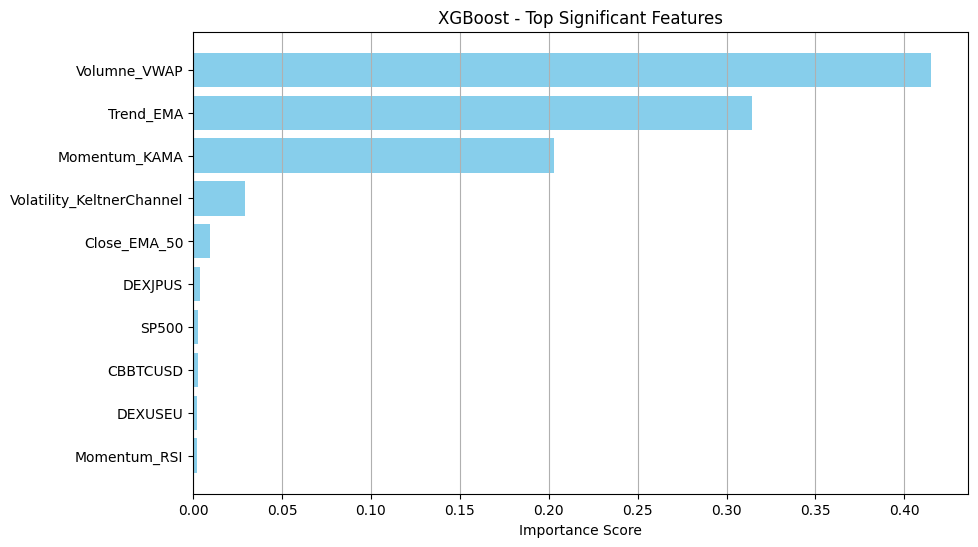

In [14]:
feature_importances = model.feature_importances_

# Create a dictionary mapping feature names to their importance scores
feature_importance_dict = dict(zip(X_train.columns, feature_importances))

# Sort features based on importance scores
sorted_features = sorted(feature_importance_dict, key=feature_importance_dict.get, reverse=True)

# Number of top features you want to display
top_n = 10  # You can change this value to display a different number of top features

# Extract top features and their importance scores
top_features = sorted_features[:top_n]
top_importance = [feature_importance_dict[feat] for feat in top_features]

# Plotting top features based on importance
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance, color='skyblue')
plt.xlabel('Importance Score')
plt.title('XGBoost - Top Significant Features')
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()